In [1]:
!pip install pyspark

In [2]:
!pip install seaborn

In [63]:
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import dataframe
from pyspark.sql.types import * # to create a dataframe of a specific type
from pyspark.sql import functions as f# importig SQL functions
from pyspark.sql.window import Window
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

In [4]:
spark = SparkSession.builder.getOrCreate()
spark

In [5]:
data = spark.read.csv("OnlineRetail.csv", inferSchema=True, header=True)

In [6]:
data.show()

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/2010 8:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|12/1/2010 8:26|     4.

In [7]:
data.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [8]:
data.toPandas().shape

(541909, 8)

In [9]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [10]:
data.groupBy("Country").count().sort("count", ascending=False).show(10)

+--------------+------+
|       Country| count|
+--------------+------+
|United Kingdom|495478|
|       Germany|  9495|
|        France|  8557|
|          EIRE|  8196|
|         Spain|  2533|
|   Netherlands|  2371|
|       Belgium|  2069|
|   Switzerland|  2002|
|      Portugal|  1519|
|     Australia|  1259|
+--------------+------+
only showing top 10 rows



In [11]:
rtl_data = data["Country", "CustomerID"].distinct().groupBy("Country").agg(count
          ("CustomerID").alias("Count")).withColumn('Total', sum('Count').over
          (Window.partitionBy())).withColumn('%', (col('Count')/col('Total'))*100).sort("Count", ascending=False)
rtl_data.show(5)
     

+--------------+-----+-----+------------------+
|       Country|Count|Total|                 %|
+--------------+-----+-----+------------------+
|United Kingdom| 3950| 4380| 90.18264840182648|
|       Germany|   95| 4380|2.1689497716894977|
|        France|   87| 4380|1.9863013698630139|
|         Spain|   31| 4380|0.7077625570776256|
|       Belgium|   25| 4380|0.5707762557077625|
+--------------+-----+-----+------------------+
only showing top 5 rows



In [12]:
rtl_data = data.filter(col("Country") == "United Kingdom")

rtl_data = rtl_data.filter(col("CustomerID").isNotNull())

print(rtl_data.toPandas().shape)
rtl_data.show(5)

(361878, 8)
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



In [13]:
rtl_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in rtl_data.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|          0|       0|          0|        0|         0|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [14]:
# To remove negative Quantities
rtl_data = rtl_data.filter(col("Quantity") > 0)
# Total Amount column
rtl_data = rtl_data.withColumn("TotalAmount", round(col("Quantity") * col("UnitPrice")))
     

In [15]:
df = rtl_data.toPandas()

In [16]:
print(df.InvoiceDate.min())
print(df.InvoiceDate.max())
df["InvoiceDate"]

1/10/2011 10:32
9/9/2011 9:52


0          12/1/2010 8:26
1          12/1/2010 8:26
2          12/1/2010 8:26
3          12/1/2010 8:26
4          12/1/2010 8:26
               ...       
354340    12/9/2011 12:31
354341    12/9/2011 12:49
354342    12/9/2011 12:49
354343    12/9/2011 12:49
354344    12/9/2011 12:49
Name: InvoiceDate, Length: 354345, dtype: object

In [17]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["InvoiceDate"]

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
354340   2011-12-09 12:31:00
354341   2011-12-09 12:49:00
354342   2011-12-09 12:49:00
354343   2011-12-09 12:49:00
354344   2011-12-09 12:49:00
Name: InvoiceDate, Length: 354345, dtype: datetime64[ns]

In [18]:
# calculating the monetary values
monetary =df.groupby("CustomerID").TotalAmount.sum()
monetary = monetary.reset_index() 
monetary.head()

,CustomerID,TotalAmount
0,12346,77184.0
1,12747,4207.0
2,12748,33956.0
3,12749,4115.0
4,12820,946.0


In [19]:
# calculating the frequency values
frequency=df.groupby("CustomerID").InvoiceNo.count()
frequency = frequency.reset_index()
frequency.head()

,CustomerID,InvoiceNo
0,12346,1
1,12747,103
2,12748,4596
3,12749,199
4,12820,59


In [20]:
LastDate=df.InvoiceDate.max()
print(LastDate)
print(pd.DateOffset(days=1))
print(df.InvoiceDate)

2011-12-09 12:49:00
<DateOffset: days=1>
0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
354340   2011-12-09 12:31:00
354341   2011-12-09 12:49:00
354342   2011-12-09 12:49:00
354343   2011-12-09 12:49:00
354344   2011-12-09 12:49:00
Name: InvoiceDate, Length: 354345, dtype: datetime64[ns]


In [21]:
#calculating our recency value
LastDate=df.InvoiceDate.max() #calculating the last date of InvoiceDate
LastDate = LastDate + pd.DateOffset(days=1)
df["Diff"] = LastDate - df.InvoiceDate
recency = df.groupby("CustomerID").Diff.min()
recency = recency.reset_index()
recency.head(10)

,CustomerID,Diff
0,12346,326 days 02:48:00
1,12747,2 days 22:15:00
2,12748,1 days 00:29:00
3,12749,4 days 02:53:00
4,12820,3 days 21:37:00
5,12821,214 days 20:58:00
6,12822,71 days 02:45:00
7,12823,75 days 05:14:00
8,12824,60 days 00:00:00
9,12826,3 days 02:24:00


In [22]:
rmf = monetary.merge(frequency, on = "CustomerID")
rmf = rmf.merge(recency, on = "CustomerID")
rmf.columns = ["CustomerID", "Monetary", "Frequence", "Recency"]
rmf.Recency=rmf.Recency.dt.days
#rmf = rmf.drop("CustomerID",axis =1) #dropping customer id and storing it into RMF1
#RMF1.Recency = RMF1.Recency.dt.days
#RMF1.head()
rmf.to_csv('rmf.csv', header=True, index=True)

In [23]:
rmf_data=spark.read.csv("rmf.csv", inferSchema=True, header=True)

In [24]:
rmf_data.show()

+---+----------+--------+---------+-------+
|_c0|CustomerID|Monetary|Frequence|Recency|
+---+----------+--------+---------+-------+
|  0|     12346| 77184.0|        1|    326|
|  1|     12747|  4207.0|      103|      2|
|  2|     12748| 33956.0|     4596|      1|
|  3|     12749|  4115.0|      199|      4|
|  4|     12820|   946.0|       59|      3|
|  5|     12821|    93.0|        6|    214|
|  6|     12822|   953.0|       46|     71|
|  7|     12823|  1761.0|        5|     75|
|  8|     12824|   399.0|       25|     60|
|  9|     12826|  1498.0|       91|      3|
| 10|     12827|   435.0|       25|      6|
| 11|     12828|  1021.0|       56|      3|
| 12|     12829|   294.0|       11|    337|
| 13|     12830|  6818.0|       38|     38|
| 14|     12831|   216.0|        9|    262|
| 15|     12832|   383.0|       27|     32|
| 16|     12833|   419.0|       24|    145|
| 17|     12834|   313.0|       18|    283|
| 18|     12836|  2631.0|      175|     59|
| 19|     12837|   136.0|       

C:\Users\LAB\AppData\Local\Temp\ipykernel_5856\1022252033.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rmf['Recency'])
C:\Users\LAB\AppData\Local\Temp\ipykernel_5856\1022252033.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rmf['Monetary'])
C:\Users\LAB\AppData\Local\Temp\ipykernel_5

<AxesSubplot: xlabel='Frequence', ylabel='Density'>

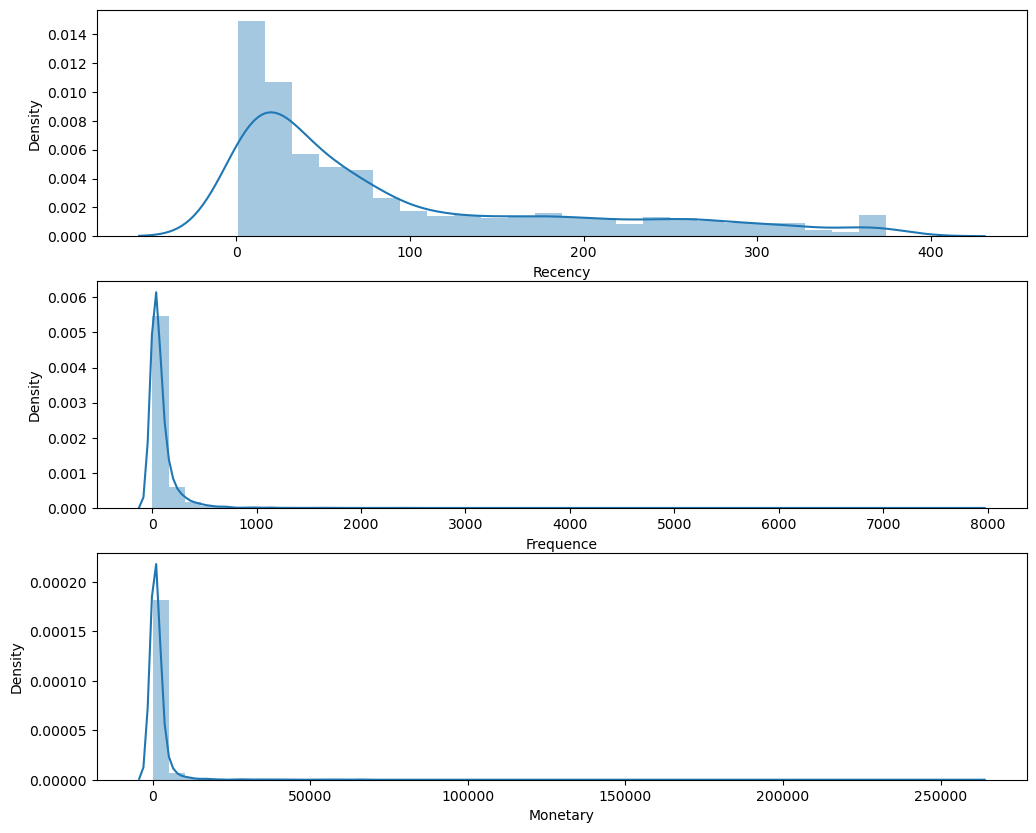

In [25]:
plt.figure(figsize=(12,10))
# Plot distribution of recency
plt.subplot(3, 1, 1)
sns.distplot(rmf['Recency'])

# Plot distribution of monetary
plt.subplot(3, 1, 3)
sns.distplot(rmf['Monetary'])

# Plot distribution of frequency
plt.subplot(3, 1, 2)
sns.distplot(rmf['Frequence'])


In [26]:
rmf_data.describe()

DataFrame[summary: string, _c0: string, CustomerID: string, Monetary: string, Frequence: string, Recency: string]

In [27]:
# remove zero and negative numbers

rfm_data = (rmf_data.withColumn("Monetary", when(col("Monetary") <= 0, 1).otherwise(col("Monetary"))))

In [28]:
features = rfm_data.columns[2:]

In [29]:
# vectorize all features
assembler = VectorAssembler(inputCols=features, outputCol="rfm_features")
assembled_data = assembler.transform(rfm_data)
assembled_data = assembled_data.select('CustomerID', 'rfm_features')
assembled_data.show(5)

+----------+--------------------+
|CustomerID|        rfm_features|
+----------+--------------------+
|     12346| [77184.0,1.0,326.0]|
|     12747|  [4207.0,103.0,2.0]|
|     12748|[33956.0,4596.0,1.0]|
|     12749|  [4115.0,199.0,4.0]|
|     12820|    [946.0,59.0,3.0]|
+----------+--------------------+
only showing top 5 rows



In [30]:
# Standardization 
scaler = StandardScaler(inputCol='rfm_features', outputCol='rfm_standardized')
data_scale = scaler.fit(assembled_data)
scaled_data = data_scale.transform(assembled_data)
scaled_data.show(5)

+----------+--------------------+--------------------+
|CustomerID|        rfm_features|    rfm_standardized|
+----------+--------------------+--------------------+
|     12346| [77184.0,1.0,326.0]|[10.3115381937557...|
|     12747|  [4207.0,103.0,2.0]|[0.56204188926630...|
|     12748|[33956.0,4596.0,1.0]|[4.53641416494571...|
|     12749|  [4115.0,199.0,4.0]|[0.54975098034961...|
|     12820|    [946.0,59.0,3.0]|[0.12638260690418...|
+----------+--------------------+--------------------+
only showing top 5 rows



In [31]:
costs = np.zeros(10)
# Apply k-means with different value of k
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('rfm_standardized')
    model = kmeans.fit(scaled_data)
    costs[k] = model.summary.trainingCost

Text(0.5, 1.0, 'Elbow Curve')

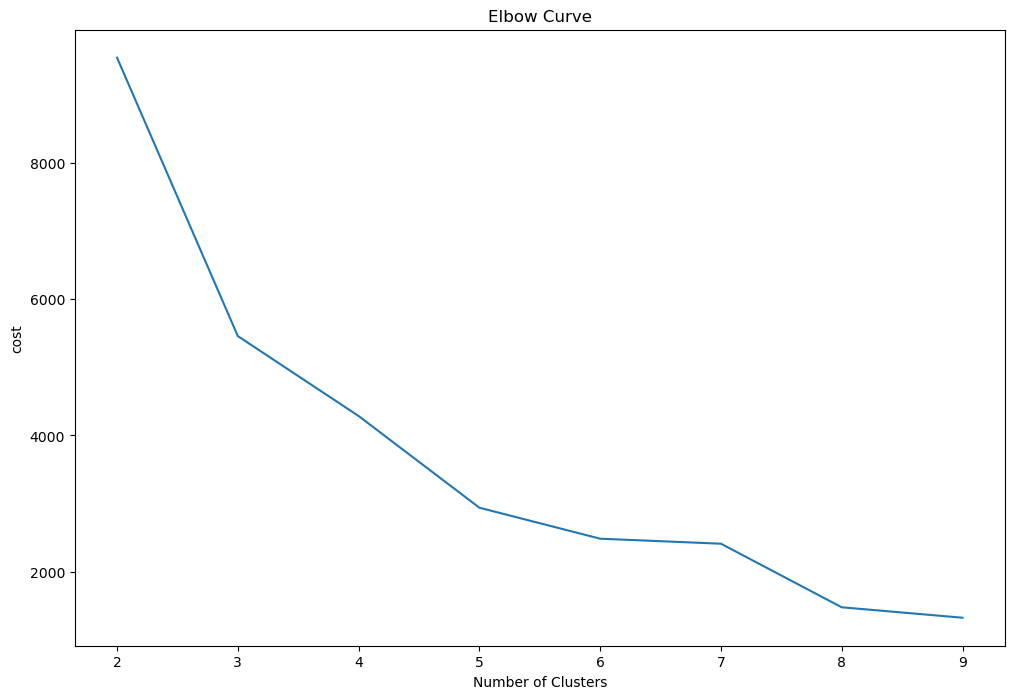

In [32]:
# Plot the cost
df_cost = pd.DataFrame(costs[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

fig, ax = plt.subplots(1, 1, figsize =(12, 8))
ax.plot(df_cost.cluster, df_cost.cost)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('cost')
ax.set_title('Elbow Curve')

In [33]:
df_cost

,cluster,cost
0,2,9548.640415
1,3,5459.652179
2,4,4286.082248
3,5,2939.182207
4,6,2484.076131
5,7,2410.453773
6,8,1476.536593
7,9,1323.310370


In [34]:
k_means = KMeans(featuresCol='rfm_standardized', k=5)
model = k_means.fit(scaled_data)
predictions = model.transform(scaled_data)

result = predictions.select('CustomerID', 'prediction')

In [35]:
result.select('prediction').distinct().collect()

[Row(prediction=1),
 Row(prediction=3),
 Row(prediction=4),
 Row(prediction=2),
 Row(prediction=0)]

In [57]:
combined_result = result.join(rfm_data, on='CustomerID', how='inner')
combined_result= combined_result.drop('_c0')
combined_result_df=combined_result.toPandas()
print(combined_result_df)

      CustomerID  prediction  Monetary  Frequence  Recency
0          12346           4   77184.0          1      326
1          12747           0    4207.0        103        2
2          12748           3   33956.0       4596        1
3          12749           0    4115.0        199        4
4          12820           0     946.0         59        3
...          ...         ...       ...        ...      ...
3916       18280           2     182.0         10      278
3917       18281           2      81.0          7      181
3918       18282           0     181.0         12        8
3919       18283           4    2140.0        756        4
3920       18287           0    1836.0         70       43

[3921 rows x 5 columns]


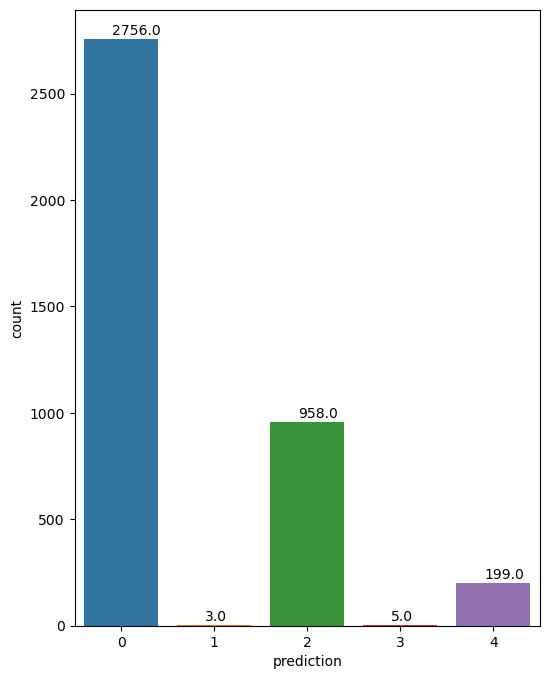

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sns.countplot(x="prediction", data=combined_result_df)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 20))

<AxesSubplot: xlabel='Monetary', ylabel='Frequence'>

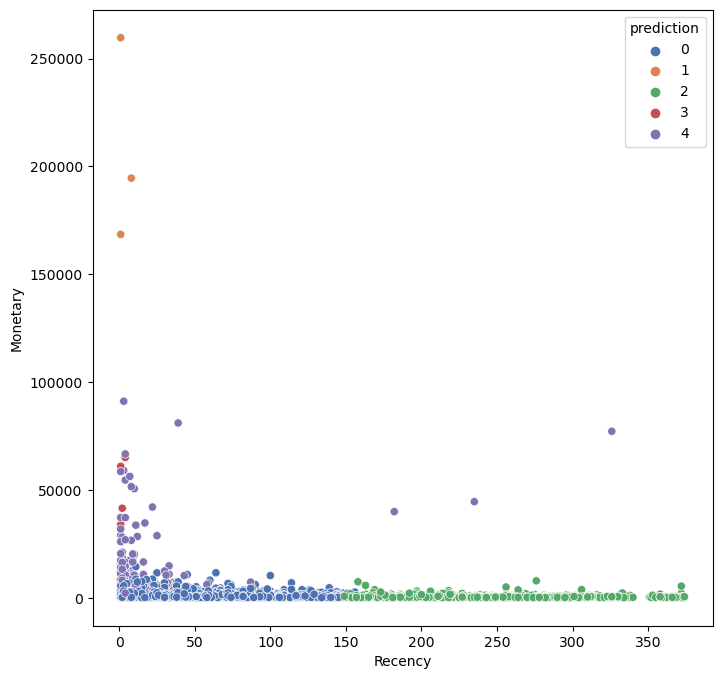

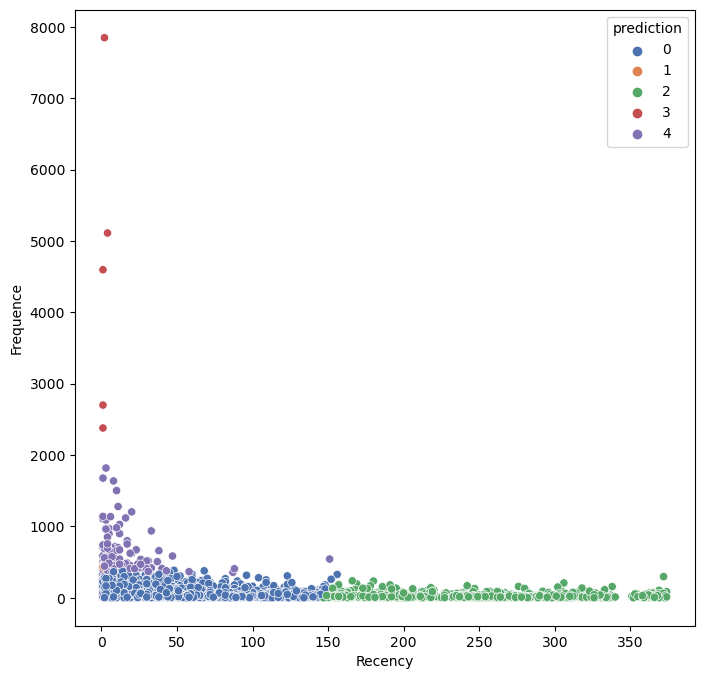

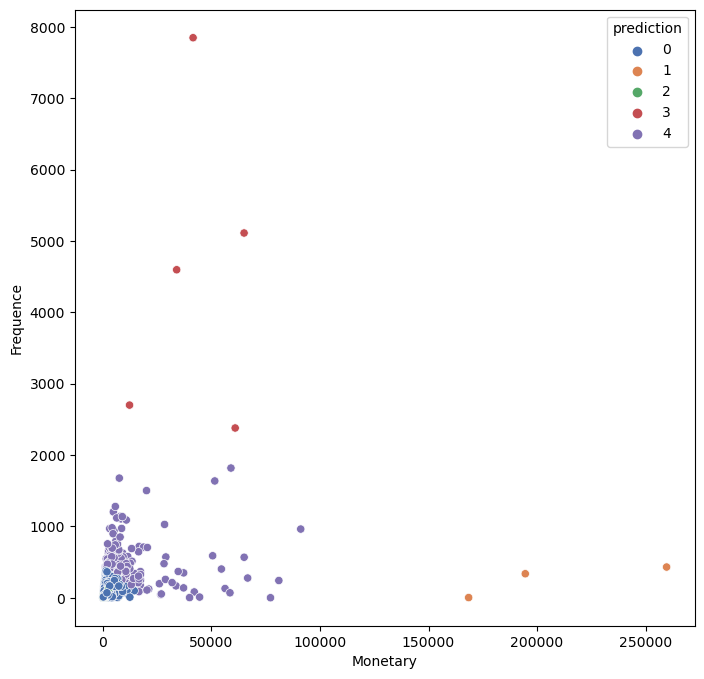

In [60]:
selected_result_df = combined_result_df#.query('Monetary < 100000').query('Frequency < 3000')

# Recency vs Monetary (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Monetary', data=selected_result_df, hue='prediction', palette="deep")

# Recency vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Frequency', data=selected_result_df, hue='prediction', palette="deep")

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Monetary', y='Frequency', data=selected_result_df, hue='prediction', palette="deep")

In [67]:
analysis = combined_result\
    .groupBy('prediction')\
    .agg(f.avg('Recency').alias('Avg Recency'),
         f.avg('Frequency').alias('Avg Frequency'),
         f.avg('Monetary').alias('Avg Monetary'))
print(analysis.toPandas())

   prediction  Avg Recency  Avg Frequency   Avg Monetary
0           1     3.333333     257.000000  207567.333333
1           3     1.800000    4526.600000   42730.000000
2           4    15.693467     490.708543   12449.246231
3           2   247.771399      27.692067     453.138831
4           0    43.891147      75.022134    1301.496372
